### In QA V5, I check whether the length of T actually plays a role, or is it the same as adjusting alpha.

Here in QA V5.2, I only vary beta.

# Conclusion

Beta is a bit more tricky to deal with. While the accuracy-alpha and accuracy-T_max graphs are always increasing, the accuracy-beta graph peaks somewhere in the middle. So from now, the strategy should be: use as large beta as possible, then sweep through different beta values to find beta_optimal.

If we have extra time, it would be good to see how beta_optimal changes as alpha changes.

In [1]:
import numpy as np
from scipy.linalg import expm
import scipy
import matplotlib.pyplot as plt
import time

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

In [3]:
sigmaI = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
sigmaX = np.array(
    [
        [0, 1],
        [1, 0],
    ]
)
sigmaBin = np.array(
    [
        [0, 0],
        [0, 1],
    ]
)

In [4]:
Values = [10, 5]
Weights = [2, 3]
Ancil = [1, 2]

alpha = 5
beta = 1
gamma = max(Values) + 1
T = 1
dt = 0.01
t_axis = np.arange(0, T, dt)[0:]

In [5]:
H0 = np.array([
[ 0.,7.14,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 7.14,0.,10.097,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,10.097,0.,12.367,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,12.367,0.,14.28,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,14.28,0.,15.966,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,15.966,0.,17.489,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,17.489,0.,18.891,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,18.891,0.,20.195,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,20.195,0.,21.42,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,21.42,0.,22.579,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,22.579,0.,23.681,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,23.681,0.,24.734,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,24.734,0.,25.744,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,25.744,0.,26.715,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,26.715,0.,27.653],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,27.653,0.,]
])
# print(H0)

eigenvals_H0, eigenvecs_H0 = np.linalg.eigh(H0)
ground_idx_H0 = eigenvals_H0.argsort()[0]
print(eigenvals_H0[ground_idx_H0])
print(eigenvecs_H0[:, ground_idx_H0])

-47.34465334125993
[-0.     0.    -0.     0.001 -0.004  0.011 -0.026  0.056 -0.106  0.182
 -0.281  0.389 -0.475  0.5   -0.428  0.25 ]


In [6]:
Hp = (
    - (Values[0] * np.kron(np.kron(np.kron(sigmaBin, sigmaI), sigmaI), sigmaI) + Values[1] * np.kron(np.kron(np.kron(sigmaI, sigmaBin), sigmaI), sigmaI))
    + gamma * (
        (Weights[0] * np.kron(np.kron(np.kron(sigmaBin, sigmaI), sigmaI), sigmaI) + Weights[1] * np.kron(np.kron(np.kron(sigmaI, sigmaBin), sigmaI), sigmaI))
      - (Ancil[0] * np.kron(np.kron(np.kron(sigmaI, sigmaI), sigmaBin), sigmaI) + Ancil[1] * np.kron(np.kron(np.kron(sigmaI, sigmaI), sigmaI), sigmaBin))
    )**2
)
# print(Hp)

eigenvals_Hp, eigenvecs_Hp = np.linalg.eigh(Hp)
ground_idx_Hp = eigenvals_Hp.argsort()[0]
print(eigenvals_Hp[ground_idx_Hp])
print(eigenvecs_Hp[:, ground_idx_Hp])


-10.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [7]:
def H(t, T=1, alpha=1, beta=1):
    return alpha * ( (1 - t/T)*beta*H0 + (t/T)*Hp )

In [8]:
psi_ini = eigenvecs_H0[:, ground_idx_H0]
# print(psi_ini)
# print(np.linalg.norm(psi_ini))

psi_correct = eigenvecs_Hp[:, ground_idx_Hp]
# print(psi_correct)

In [9]:
beta_list = np.arange(1e-1, 1e1, 1e-1)
accuracy_list = []

for beta in beta_list:
    # start_time = time.time()

    junrui_unitary = np.identity(len(H0))
    for t in t_axis:
        junrui_unitary = expm(-1j * H(t, T=T, alpha=alpha, beta=beta) * dt) @ junrui_unitary

    psi_final = junrui_unitary @ psi_ini

    accuracy = np.abs( np.dot(psi_correct, psi_final) )**2
    accuracy_list.append(accuracy)

    # end_time = time.time()
    # print(f"alpha = {alpha}, loop time: {end_time - start_time}")



In [10]:
print(accuracy_list)

[np.float64(0.31182469444824895), np.float64(0.33619572298883377), np.float64(0.3744139909375848), np.float64(0.435184053056206), np.float64(0.4993304600014969), np.float64(0.5647595886136809), np.float64(0.6534712522981739), np.float64(0.7025318640502), np.float64(0.791937432296638), np.float64(0.8344712168975509), np.float64(0.888800856658309), np.float64(0.9373200612379817), np.float64(0.95392547683865), np.float64(0.9638560593772515), np.float64(0.9942182981213787), np.float64(0.9940693065610646), np.float64(0.9938103734528538), np.float64(0.992259166863598), np.float64(0.9908753112736916), np.float64(0.9928521047606946), np.float64(0.9917647096963086), np.float64(0.9843540050767103), np.float64(0.9861689447058826), np.float64(0.9875408551595303), np.float64(0.9810745726929664), np.float64(0.9793740812402117), np.float64(0.9796454352132787), np.float64(0.9740385613998677), np.float64(0.9708968004557336), np.float64(0.9706835780531878), np.float64(0.9660375183925407), np.float64(0.9

0.9942182981213787


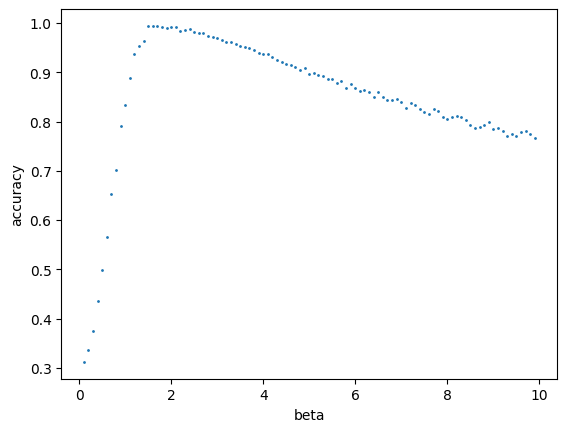

In [13]:
plt.scatter(beta_list, accuracy_list, s=1)
plt.xlabel("beta")
plt.ylabel("accuracy")
print(max(accuracy_list))

In [16]:
print(beta_list[9])
print(accuracy_list[9])

1.0
0.8344712168975509


In [21]:
accuracy_list = np.array(accuracy_list)
print(accuracy_list.argmax())
print(accuracy_list[accuracy_list.argmax()])
print(f"beta_optimal: {beta_list[accuracy_list.argmax()]}")

14
0.9942182981213787
beta_optimal: 1.5
